# 価値関数

```{math}
\newcommand{\E}{{\mathrm E}}
\newcommand{\underE}[2]{\underset{\begin{subarray}{c}#1 \end{subarray}}{\E}\left[ #2 \right]}
\newcommand{\Epi}[1]{\underset{\begin{subarray}{c}\tau \sim \pi \end{subarray}}{\E}\left[ #1 \right]}
```


本章では，価値関数/行動価値関数というものについて見ていきます．
価値関数/行動価値関数とは直感的に捉えると，ある状態$s$や状態行動対$(s,a)$が，どのくらいの価値を持つかを表すものです．
これらは強化学習理論の基礎となる，非常に重要な関数となっています．

## 定義

まずは，一般的に用いられる価値関数/行動価値関数の定義を確認します．

- 価値関数(Value Function)

  $$V^\pi(s) = \underE{\pi}{G_t | S_t = s}$$ (vpi_definition)

- 行動価値関数(Action Value Function)

  $$Q^\pi(s,a) = \underE{\pi}{G_t | S_t = s, A_t = a}$$ (qpi_definition)

定義より，価値関数$V^\pi(s)$は「ある状態$s$から方策$\pi$に従って行動した場合の得られる期待割引累積報酬」と解釈できます．
また，行動価値関数は「ある状態$s$で，ある行動$a$を取った後，方策$\pi$に従って行動した場合の得られる期待割引累積報酬」と解釈できます．

２つの違いは，価値関数$V^\pi(s)$は最初の行動$A_t$が方策に従ってサンプルされるのに対して，行動価値関数$Q^\pi(s,a)$では$A_t$が引数によって与えられるという点です．なので，2 つの関数には以下の関係が成り立ちます．

$$V^\pi(s) = \underE{a \sim \pi}{Q^\pi(s, a)}$$ (vpi_qpi_relation)

## モンテカルロ法による価値関数/行動価値関数の推定

価値関数/行動価値関数の定義から，

1. 方策$\pi$から$G_t$の値をサンプルする．
2. サンプルされたデータの期待値から，$V^\pi(s), Q^\pi(s, a)$を推定する．

という非常にシンプルな推定方法を考えることが出来ます．
このようなコンセプトを持った手法はモンテカルロ法と言われています．

実際にモンテカルロ法をシミュレーションに適用する様子を見ていきましょう．

### 実験設定

環境として，OpenAI Gym の[FrozenLake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/)を用います．
この環境では状態空間が各マスに対応した$\mathcal{S} = \{0,1,\cdots,15\}$，行動空間が進む向きに対応した$\mathcal{A} = \{0,1,2,3\}$となっており，スタート地点からLakeに落ちずにゴール地点にたどり着くことを目的としています．
環境に関する設定は，ドキュメントを参照してください．


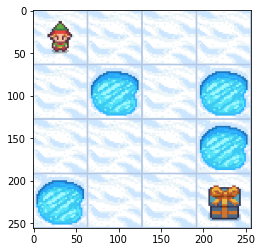

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt
import gym

gym.logger.setLevel(gym.logger.DISABLED)  # Disable Logger

env = gym.make(
    "FrozenLake-v1",
    desc=["SFFF", "FHFH", "FFFH", "HFFG"],
    map_name="4x4",
)

env.reset()

plt.imshow(env.render(mode='rgb_array'))


次に，各パラメータを設定します．
環境から状態数と行動数を取得し，割引率$\gamma = 0.99$と設定します


In [23]:
GAMMA = 0.99
state_size = env.observation_space.n
action_size = env.action_space.n

print(f"state_size = {state_size}, action_size = {action_size}")


state_size = 16, action_size = 4


価値推定の対象となる方策は，ランダム方策$\pi(a|s) = \frac{1}{4}, \forall s \in \mathcal{S}, a \in \mathcal{A}$とします


In [24]:
def policy(state):
    return env.action_space.sample()  # 行動を行動空間からランダムにサンプルする


### 経験データの収集

ここから，実際の環境から方策を用いて，経験を収集する関数を作っていきます．
ここで，経験とはエージェントが環境と相互作用し，得られる状態/行動/報酬の履歴

$$\{S_0,A_0,R_0,\cdots,S_{T-1},A_{T-1},R_{T-1},S_T\}$$

を表します．
しかし，多くの強化学習アルゴリズムでは便宜上，(状態,行動,次の状態,報酬)の一つの遷移を表したタプルの系列として経験を保存します．

$$\{(S_0, A_0, S_1, R_0), (S_1, A_1, S_2, R_1), \cdots, (S_{T-1}, A_{T-1}, S_{T}, R_{T-1})\}$$

以下は，一つの遷移$(S_t, A_t, S_{t+1}, R_t)$を表す[dataclass](https://docs.python.org/ja/3.10/library/dataclasses.html)(C言語のstructのようなもの)です．


In [25]:
from dataclasses import dataclass


@dataclass
class Transition:
    state: int  # 状態
    action: int  # 行動
    reward: float  # 報酬
    next_state: int  # 次の状態


次に，エピソードひとつ分の経験を生成する関数を定義します．
この関数の中では`episode`という配列が$\{(S_0, A_0, S_1, R_0), (S_1, A_1, S_2, R_1), \cdots, (S_{T-1}, A_{T-1}, S_{T}, R_{T-1})\}$に対応しています．


In [26]:
from typing import Callable


def generate_episode(env: gym.Env, policy: Callable):
    episode: list[Transition] = []  # 経験を保存するリスト
    state = env.reset()  # 環境をリセット
    while True:  # エピソードが終了するまでループ
        action = policy(state)  # 方策から行動をサンプル
        next_state, reward, done, _ = env.step(action)  # 行動を実行する．
        episode.append(
            Transition(state, action, reward, next_state)
        )  # (S_t, A_t, S_{t+1}, R_t)のタプルを保存
        if done:
            break  # next_stateが終了状態である場合はループから出る
        else:
            state = next_state  # そうでない場合は状態を更新

    return episode


### 行動価値の推定

FrozenLake 環境におけるランダム方策の行動価値関数を推定していきます．
価値関数に関しては式{eq}`vpi_qpi_relation`より，

$$V^\pi(s) = \underE{a \sim \pi}{Q^\pi(s, a)} = \sum_{a \in \mathcal{A}} \pi(a|s) Q^\pi(s,a) = \sum_{a \in \{0,1,2,3\}} \frac{1}{4} Q^\pi(s,a)$$

とすれば良いので，ここでは行動価値関数のみを推定します．

まずは各状態行動対$(S_t = s,A_t = a)$から，サンプルされた割引報酬和$G_t$を保存する辞書型のコンテナ`returns`を初期化します．
key が状態行動対$(S_t = s,A_t = a)$となっており，value が経験からサンプルされた$S_t = s, A_t = a$のときの割引累積報酬$G_t$のリストとなります.


In [27]:
returns = {(s, a): [] for s in range(state_size) for a in range(action_size)}


行動価値関数`q`の推定値を 0 に初期化します．行動価値関数は$\mathbb{R}^{|\mathcal{S}| \times |\mathcal{A}|}$の行列で保存され，行が状態，列が行動に対応します．

||$a=0$|$a=1$|$a=2$|$a=3$|
|---|---|---|---|---|
|$s=0$|$Q(0,0)$|$Q(0,1)$|$Q(0,2)$|$Q(0,3)$|
|$s=1$|$Q(1,0)$|$Q(1,1)$|$Q(1,2)$|$Q(1,3)$|
|$\cdots$|$\cdots$|$\cdots$|$\cdots$|$\cdots$|

In [28]:
import numpy as np

q = np.zeros((state_size, action_size))


それでは，これらをもとに，行動価値関数を推定していきます．
今回は，推定のため 1000 エピソードを収集することにしましょう．
各更新ループの一番最初でエピソード 1 つ分を収集します．

そこで得られた配列から，割引累積報酬$G_t$を計算します．ここで，$G_t$の定義式{eq}`g_t`より

$$G_{t} = R_t + \gamma G_{t+1}$$ (g_t_recursion)

のような時間方向後ろ向きに再帰的な関係関係を満たすため，これを利用し$G_{t}$を求めます．

$Q(s,a)$は定義式{eq}`qpi_definition`から`returns[state, action] = [G0, G1, ...]`の平均値をとって推定します．


In [29]:
for _ in range(1000):
    episode = generate_episode(env, policy)
    g = 0.0  # G_T = 0 として初期化
    for transition in reversed(episode):  # 経験を末尾から順に利用
        g = transition.reward + GAMMA * g  # G_t を計算
        returns[(transition.state, transition.action)].append(g)  # 状態(s,a)から
        q[transition.state, transition.action] = np.mean(
            returns[(transition.state, transition.action)]
        )  # returns[state, action] の平均をQ(s,a)の推定値とする．


これらより，行動価値関数の推定値が求まります．


In [32]:
print(f"q =\n{q}")


q =
[[0.00879326 0.00433521 0.01288201 0.00966315]
 [0.00539421 0.0111504  0.00582179 0.00521498]
 [0.0133604  0.01859533 0.01892844 0.        ]
 [0.01116972 0.01458681 0.         0.01398515]
 [0.01117291 0.00730217 0.00566324 0.00555855]
 [0.         0.         0.         0.        ]
 [0.         0.04312658 0.09278021 0.02161914]
 [0.         0.         0.         0.        ]
 [0.         0.01530218 0.02907016 0.0159675 ]
 [0.03864188 0.08005775 0.13375744 0.064421  ]
 [0.11387897 0.15652188 0.24667912 0.15386007]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.0441045  0.13466702 0.06213769 0.19781035]
 [0.31848795 0.30943688 0.36460909 0.6568429 ]
 [0.         0.         0.         0.        ]]


価値関数は，方策が一様ランダムであるため，各状態の全ての行動価値の平均を取ることにより求まります．

In [31]:
v = np.mean(q, axis=1)
print(f"v =\n{v}")

array([0.00891841, 0.00689534, 0.01272104, 0.00993542, 0.00742422,
       0.        , 0.03938148, 0.        , 0.01508496, 0.07921952,
       0.16773501, 0.        , 0.        , 0.10967989, 0.4123442 ,
       0.        ])